In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import time
import os

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


Load the Preprocessed Data

In [4]:
print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

# Define paths
MODEL_INPUT_DIR = '../data/model_input/'

# Load training data
X_train = pd.read_csv(os.path.join(MODEL_INPUT_DIR, 'X_train.csv'))
y_train = pd.read_csv(os.path.join(MODEL_INPUT_DIR, 'y_train.csv'))

# Load validation data
X_val = pd.read_csv(os.path.join(MODEL_INPUT_DIR, 'X_val.csv'))
y_val = pd.read_csv(os.path.join(MODEL_INPUT_DIR, 'y_val.csv'))

# Load test data
X_test = pd.read_csv(os.path.join(MODEL_INPUT_DIR, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(MODEL_INPUT_DIR, 'y_test.csv'))

# Convert y dataframes to series (if they're single column)
if y_train.shape[1] == 1:
    y_train = y_train.iloc[:, 0]
    y_val = y_val.iloc[:, 0]
    y_test = y_test.iloc[:, 0]

print(f"\n📊 Data loaded successfully!")
print(f"   Training set:   {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"   Validation set: {X_val.shape[0]:,} samples")
print(f"   Test set:       {X_test.shape[0]:,} samples")
print(f"\n   Target variable: {y_train.name if hasattr(y_train, 'name') else 'Implied Volatility (iv)'}")
print(f"\n   Features: {list(X_train.columns)}")


LOADING DATA

📊 Data loaded successfully!
   Training set:   2,012,234 samples, 3 features
   Validation set: 431,193 samples
   Test set:       431,194 samples

   Target variable: iv

   Features: ['T_years', 'moneyness', 'risk_free_rate']


Model 1 - Random Forest

In [5]:
print("\n" + "="*60)
print("MODEL 1: RANDOM FOREST")
print("="*60)

# Train Random Forest
print("\n🌲 Training Random Forest...")
start_time = time.time()

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)
rf_train_time = time.time() - start_time

# Predictions
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_val)
rf_test_pred = rf_model.predict(X_test)

# Evaluate
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_val_rmse = np.sqrt(mean_squared_error(y_val, rf_val_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))

rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_val_r2 = r2_score(y_val, rf_val_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)

rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_val_mae = mean_absolute_error(y_val, rf_val_pred)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)

print(f"\n✅ Random Forest training complete in {rf_train_time:.2f} seconds")
print(f"\n   Training Metrics:")
print(f"      RMSE: {rf_train_rmse:.6f}")
print(f"      R²:   {rf_train_r2:.6f}")
print(f"      MAE:  {rf_train_mae:.6f}")
print(f"\n   Validation Metrics:")
print(f"      RMSE: {rf_val_rmse:.6f}")
print(f"      R²:   {rf_val_r2:.6f}")
print(f"      MAE:  {rf_val_mae:.6f}")
print(f"\n   Test Metrics:")
print(f"      RMSE: {rf_test_rmse:.6f}")
print(f"      R²:   {rf_test_r2:.6f}")
print(f"      MAE:  {rf_test_mae:.6f}")

# Feature Importance
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n   Top 5 Important Features:")
for idx, row in feature_importance_rf.head().iterrows():
    print(f"      {row['feature']}: {row['importance']:.4f}")


MODEL 1: RANDOM FOREST

🌲 Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s



✅ Random Forest training complete in 106.69 seconds

   Training Metrics:
      RMSE: 0.039569
      R²:   0.481611
      MAE:  0.028570

   Validation Metrics:
      RMSE: 0.076135
      R²:   -2.019246
      MAE:  0.072246

   Test Metrics:
      RMSE: 0.073103
      R²:   -1.740954
      MAE:  0.067511

   Top 5 Important Features:
      moneyness: 0.8919
      T_years: 0.1081
      risk_free_rate: 0.0000


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


Model 2 - XGBoost

In [6]:
print("\n" + "="*60)
print("MODEL 2: XGBOOST")
print("="*60)

# Train XGBoost
print("\n🚀 Training XGBoost...")
start_time = time.time()

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

xgb_model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)], 
              verbose=False)
xgb_train_time = time.time() - start_time

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_val)
xgb_test_pred = xgb_model.predict(X_test)

# Evaluate
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_pred))
xgb_val_rmse = np.sqrt(mean_squared_error(y_val, xgb_val_pred))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))

xgb_train_r2 = r2_score(y_train, xgb_train_pred)
xgb_val_r2 = r2_score(y_val, xgb_val_pred)
xgb_test_r2 = r2_score(y_test, xgb_test_pred)

xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_val_mae = mean_absolute_error(y_val, xgb_val_pred)
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)

print(f"\n✅ XGBoost training complete in {xgb_train_time:.2f} seconds")
print(f"\n   Training Metrics:")
print(f"      RMSE: {xgb_train_rmse:.6f}")
print(f"      R²:   {xgb_train_r2:.6f}")
print(f"      MAE:  {xgb_train_mae:.6f}")
print(f"\n   Validation Metrics:")
print(f"      RMSE: {xgb_val_rmse:.6f}")
print(f"      R²:   {xgb_val_r2:.6f}")
print(f"      MAE:  {xgb_val_mae:.6f}")
print(f"\n   Test Metrics:")
print(f"      RMSE: {xgb_test_rmse:.6f}")
print(f"      R²:   {xgb_test_r2:.6f}")
print(f"      MAE:  {xgb_test_mae:.6f}")

# Feature Importance
feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n   Top 5 Important Features:")
for idx, row in feature_importance_xgb.head().iterrows():
    print(f"      {row['feature']}: {row['importance']:.4f}")


MODEL 2: XGBOOST

🚀 Training XGBoost...

✅ XGBoost training complete in 7.73 seconds

   Training Metrics:
      RMSE: 0.043518
      R²:   0.372975
      MAE:  0.032125

   Validation Metrics:
      RMSE: 0.075435
      R²:   -1.963948
      MAE:  0.071800

   Test Metrics:
      RMSE: 0.070800
      R²:   -1.570993
      MAE:  0.065194

   Top 5 Important Features:
      moneyness: 0.8717
      T_years: 0.1283
      risk_free_rate: 0.0000


Model 3 - Neural Network (MLP)

In [7]:
print("\n" + "="*60)
print("MODEL 3: NEURAL NETWORK (Multi-Layer Perceptron)")
print("="*60)

# Train Neural Network
print("\n🧠 Training Neural Network...")
start_time = time.time()

mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True
)

mlp_model.fit(X_train, y_train)
mlp_train_time = time.time() - start_time

# Predictions
mlp_train_pred = mlp_model.predict(X_train)
mlp_val_pred = mlp_model.predict(X_val)
mlp_test_pred = mlp_model.predict(X_test)

# Evaluate
mlp_train_rmse = np.sqrt(mean_squared_error(y_train, mlp_train_pred))
mlp_val_rmse = np.sqrt(mean_squared_error(y_val, mlp_val_pred))
mlp_test_rmse = np.sqrt(mean_squared_error(y_test, mlp_test_pred))

mlp_train_r2 = r2_score(y_train, mlp_train_pred)
mlp_val_r2 = r2_score(y_val, mlp_val_pred)
mlp_test_r2 = r2_score(y_test, mlp_test_pred)

mlp_train_mae = mean_absolute_error(y_train, mlp_train_pred)
mlp_val_mae = mean_absolute_error(y_val, mlp_val_pred)
mlp_test_mae = mean_absolute_error(y_test, mlp_test_pred)

print(f"\n✅ Neural Network training complete in {mlp_train_time:.2f} seconds")
print(f"\n   Training Metrics:")
print(f"      RMSE: {mlp_train_rmse:.6f}")
print(f"      R²:   {mlp_train_r2:.6f}")
print(f"      MAE:  {mlp_train_mae:.6f}")
print(f"\n   Validation Metrics:")
print(f"      RMSE: {mlp_val_rmse:.6f}")
print(f"      R²:   {mlp_val_r2:.6f}")
print(f"      MAE:  {mlp_val_mae:.6f}")
print(f"\n   Test Metrics:")
print(f"      RMSE: {mlp_test_rmse:.6f}")
print(f"      R²:   {mlp_test_r2:.6f}")
print(f"      MAE:  {mlp_test_mae:.6f}")


MODEL 3: NEURAL NETWORK (Multi-Layer Perceptron)

🧠 Training Neural Network...
Iteration 1, loss = 0.00117175
Validation score: 0.311438
Iteration 2, loss = 0.00099246
Validation score: 0.345290
Iteration 3, loss = 0.00098531
Validation score: 0.352757
Iteration 4, loss = 0.00098285
Validation score: 0.335541
Iteration 5, loss = 0.00098193
Validation score: 0.346996
Iteration 6, loss = 0.00098085
Validation score: 0.334150
Iteration 7, loss = 0.00098032
Validation score: 0.344966
Iteration 8, loss = 0.00098040
Validation score: 0.352623
Iteration 9, loss = 0.00097964
Validation score: 0.354649
Iteration 10, loss = 0.00097934
Validation score: 0.351797
Iteration 11, loss = 0.00097914
Validation score: 0.349288
Iteration 12, loss = 0.00097933
Validation score: 0.353051
Iteration 13, loss = 0.00097899
Validation score: 0.353063
Iteration 14, loss = 0.00097885
Validation score: 0.352991
Iteration 15, loss = 0.00097899
Validation score: 0.350052
Iteration 16, loss = 0.00097889
Validation s

Model Comparison

In [8]:
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Neural Network'],
    'Train_RMSE': [rf_train_rmse, xgb_train_rmse, mlp_train_rmse],
    'Val_RMSE': [rf_val_rmse, xgb_val_rmse, mlp_val_rmse],
    'Test_RMSE': [rf_test_rmse, xgb_test_rmse, mlp_test_rmse],
    'Train_R2': [rf_train_r2, xgb_train_r2, mlp_train_r2],
    'Val_R2': [rf_val_r2, xgb_val_r2, mlp_val_r2],
    'Test_R2': [rf_test_r2, xgb_test_r2, mlp_test_r2],
    'Train_MAE': [rf_train_mae, xgb_train_mae, mlp_train_mae],
    'Val_MAE': [rf_val_mae, xgb_val_mae, mlp_val_mae],
    'Test_MAE': [rf_test_mae, xgb_test_mae, mlp_test_mae],
    'Training_Time': [rf_train_time, xgb_train_time, mlp_train_time]
})

print("\n📊 Performance Metrics:\n")
print(comparison_df.to_string(index=False))

# Find best model
best_model_idx = comparison_df['Test_RMSE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model (lowest Test RMSE): {best_model_name}")


MODEL COMPARISON SUMMARY

📊 Performance Metrics:

         Model  Train_RMSE  Val_RMSE  Test_RMSE  Train_R2    Val_R2   Test_R2  Train_MAE  Val_MAE  Test_MAE  Training_Time
 Random Forest    0.039569  0.076135   0.073103  0.481611 -2.019246 -1.740954   0.028570 0.072246  0.067511     106.686797
       XGBoost    0.043518  0.075435   0.070800  0.372975 -1.963948 -1.570993   0.032125 0.071800  0.065194       7.726226
Neural Network    0.044056  0.076965   0.071820  0.357375 -2.085417 -1.645602   0.032551 0.073514  0.066259     304.098046

🏆 Best Model (lowest Test RMSE): XGBoost


Visualizations - Performance Comparison

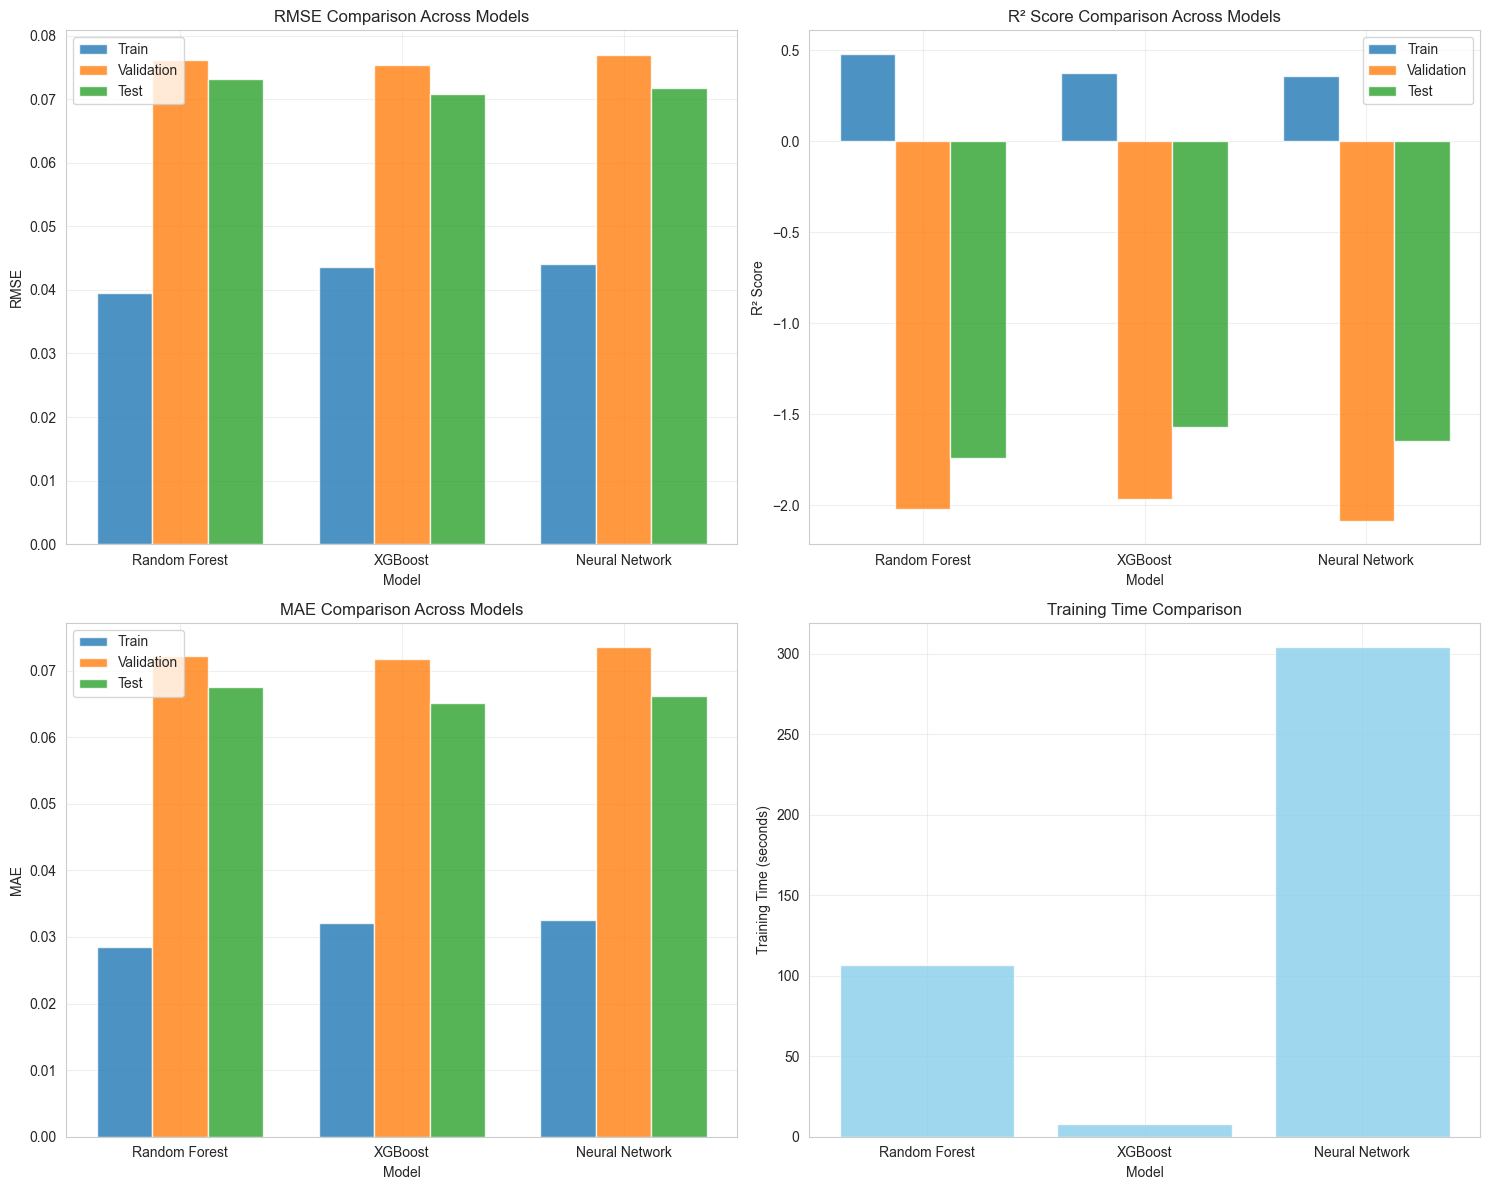

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# RMSE Comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(comparison_df))
width = 0.25
ax1.bar(x_pos - width, comparison_df['Train_RMSE'], width, label='Train', alpha=0.8)
ax1.bar(x_pos, comparison_df['Val_RMSE'], width, label='Validation', alpha=0.8)
ax1.bar(x_pos + width, comparison_df['Test_RMSE'], width, label='Test', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE Comparison Across Models')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Model'])
ax1.legend()
ax1.grid(True, alpha=0.3)

# R² Comparison
ax2 = axes[0, 1]
ax2.bar(x_pos - width, comparison_df['Train_R2'], width, label='Train', alpha=0.8)
ax2.bar(x_pos, comparison_df['Val_R2'], width, label='Validation', alpha=0.8)
ax2.bar(x_pos + width, comparison_df['Test_R2'], width, label='Test', alpha=0.8)
ax2.set_xlabel('Model')
ax2.set_ylabel('R² Score')
ax2.set_title('R² Score Comparison Across Models')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison_df['Model'])
ax2.legend()
ax2.grid(True, alpha=0.3)

# MAE Comparison
ax3 = axes[1, 0]
ax3.bar(x_pos - width, comparison_df['Train_MAE'], width, label='Train', alpha=0.8)
ax3.bar(x_pos, comparison_df['Val_MAE'], width, label='Validation', alpha=0.8)
ax3.bar(x_pos + width, comparison_df['Test_MAE'], width, label='Test', alpha=0.8)
ax3.set_xlabel('Model')
ax3.set_ylabel('MAE')
ax3.set_title('MAE Comparison Across Models')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(comparison_df['Model'])
ax3.legend()
ax3.grid(True, alpha=0.3)

# Training Time Comparison
ax4 = axes[1, 1]
ax4.bar(comparison_df['Model'], comparison_df['Training_Time'], alpha=0.8, color='skyblue')
ax4.set_xlabel('Model')
ax4.set_ylabel('Training Time (seconds)')
ax4.set_title('Training Time Comparison')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Visualizations - Predictions vs Actual

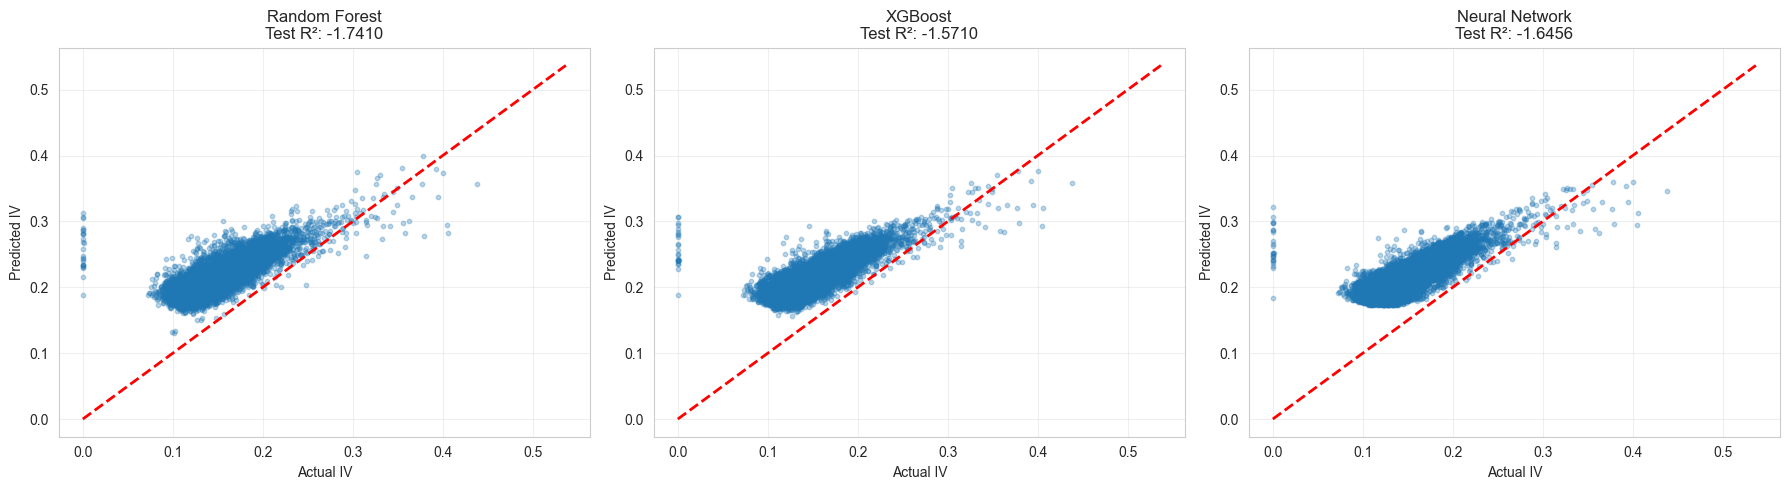

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sample for visualization (use subset if data is too large)
sample_size = min(5000, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)

# Random Forest
ax1 = axes[0]
ax1.scatter(y_test.iloc[sample_indices], rf_test_pred[sample_indices], alpha=0.3, s=10)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual IV')
ax1.set_ylabel('Predicted IV')
ax1.set_title(f'Random Forest\nTest R²: {rf_test_r2:.4f}')
ax1.grid(True, alpha=0.3)

# XGBoost
ax2 = axes[1]
ax2.scatter(y_test.iloc[sample_indices], xgb_test_pred[sample_indices], alpha=0.3, s=10)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual IV')
ax2.set_ylabel('Predicted IV')
ax2.set_title(f'XGBoost\nTest R²: {xgb_test_r2:.4f}')
ax2.grid(True, alpha=0.3)

# Neural Network
ax3 = axes[2]
ax3.scatter(y_test.iloc[sample_indices], mlp_test_pred[sample_indices], alpha=0.3, s=10)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax3.set_xlabel('Actual IV')
ax3.set_ylabel('Predicted IV')
ax3.set_title(f'Neural Network\nTest R²: {mlp_test_r2:.4f}')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Feature Importance Visualization

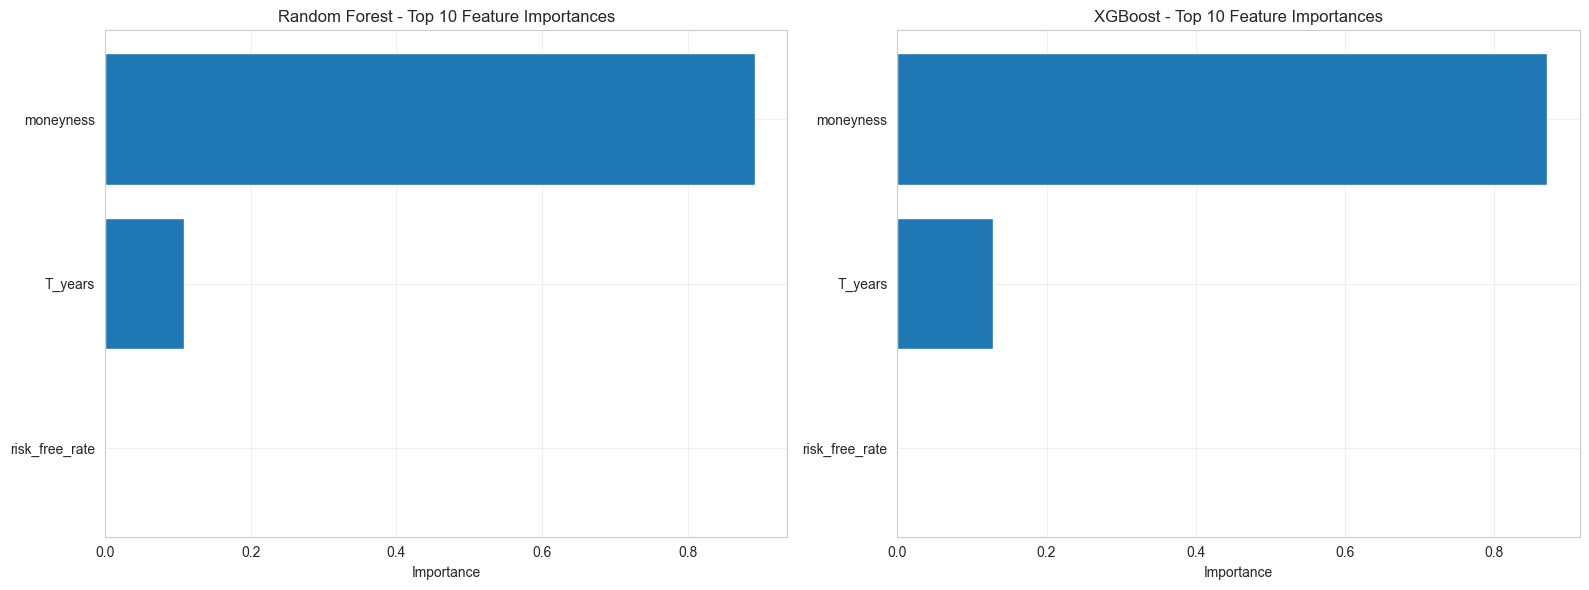


✅ MODEL TRAINING AND EVALUATION COMPLETE!


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
ax1 = axes[0]
top_n = 10
top_features_rf = feature_importance_rf.head(top_n)
ax1.barh(range(len(top_features_rf)), top_features_rf['importance'])
ax1.set_yticks(range(len(top_features_rf)))
ax1.set_yticklabels(top_features_rf['feature'])
ax1.set_xlabel('Importance')
ax1.set_title(f'Random Forest - Top {top_n} Feature Importances')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)

# XGBoost Feature Importance
ax2 = axes[1]
top_features_xgb = feature_importance_xgb.head(top_n)
ax2.barh(range(len(top_features_xgb)), top_features_xgb['importance'])
ax2.set_yticks(range(len(top_features_xgb)))
ax2.set_yticklabels(top_features_xgb['feature'])
ax2.set_xlabel('Importance')
ax2.set_title(f'XGBoost - Top {top_n} Feature Importances')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✅ MODEL TRAINING AND EVALUATION COMPLETE!")
print("="*60)

Implied Volatility Surface Visualization


IMPLIED VOLATILITY SURFACE VISUALIZATION

📊 Creating IV surface visualizations...
Available features: ['T_years', 'moneyness', 'risk_free_rate']


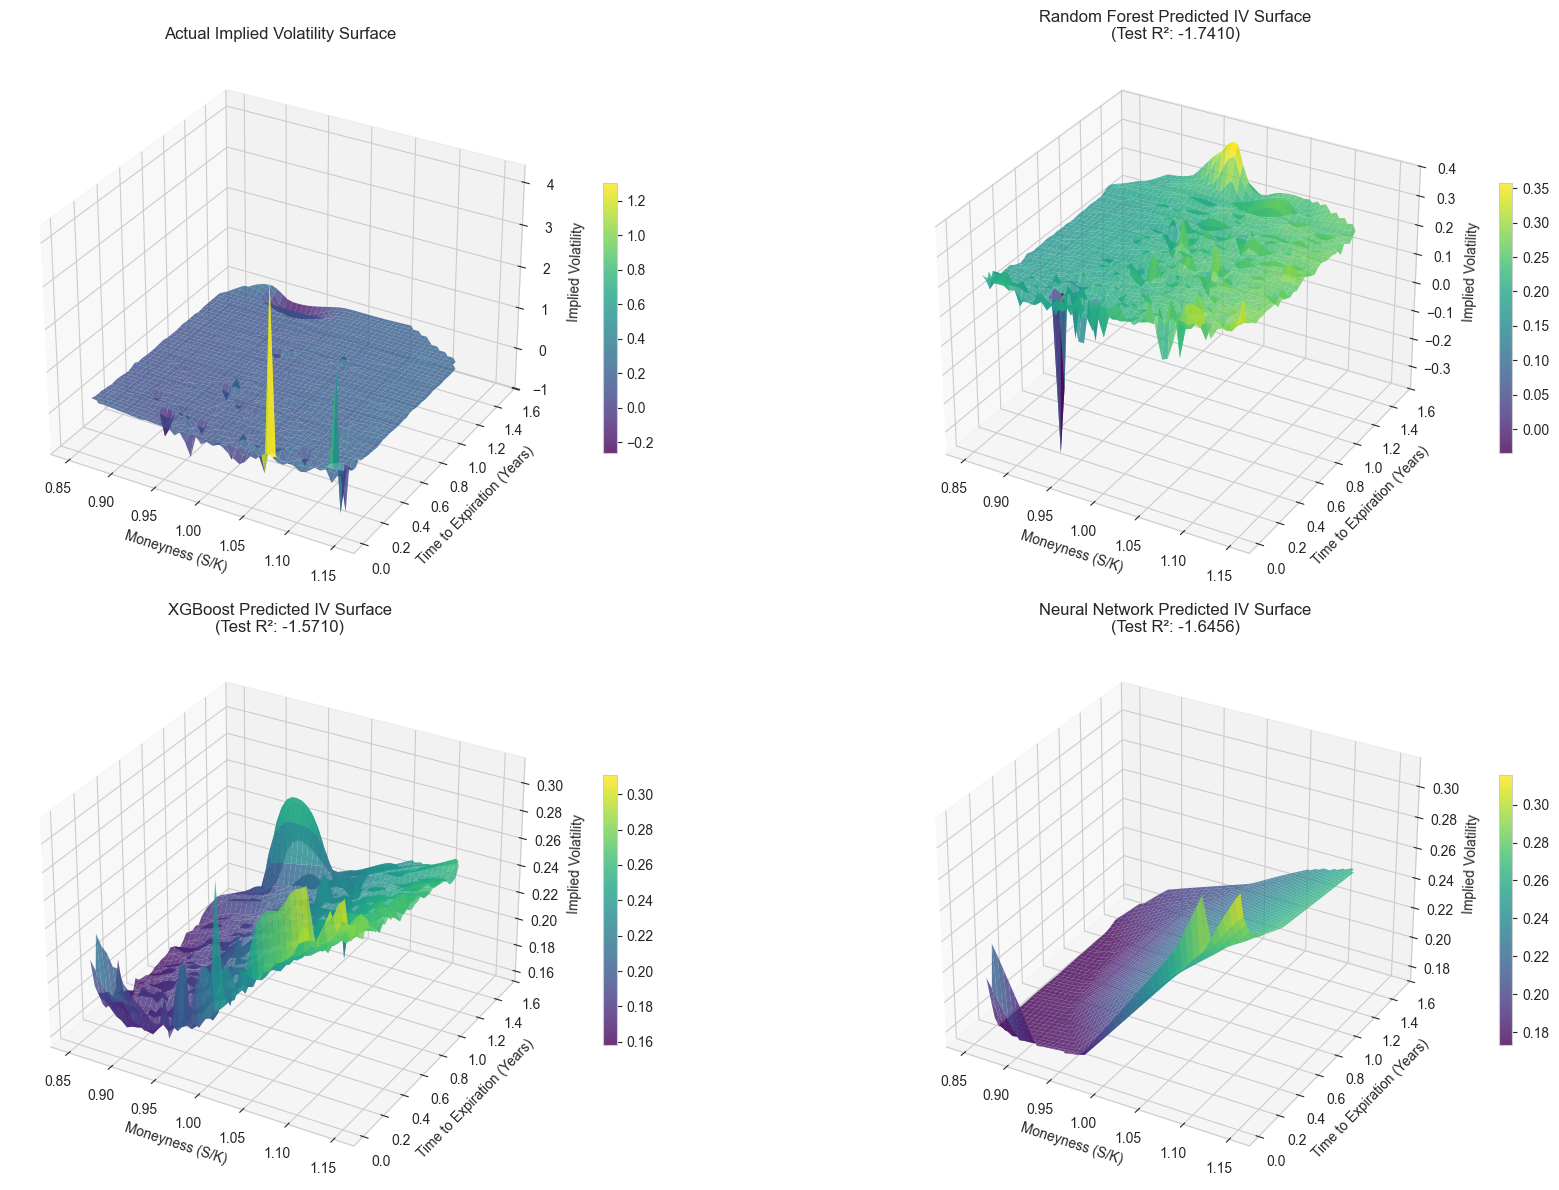


✅ IV surface visualizations complete!


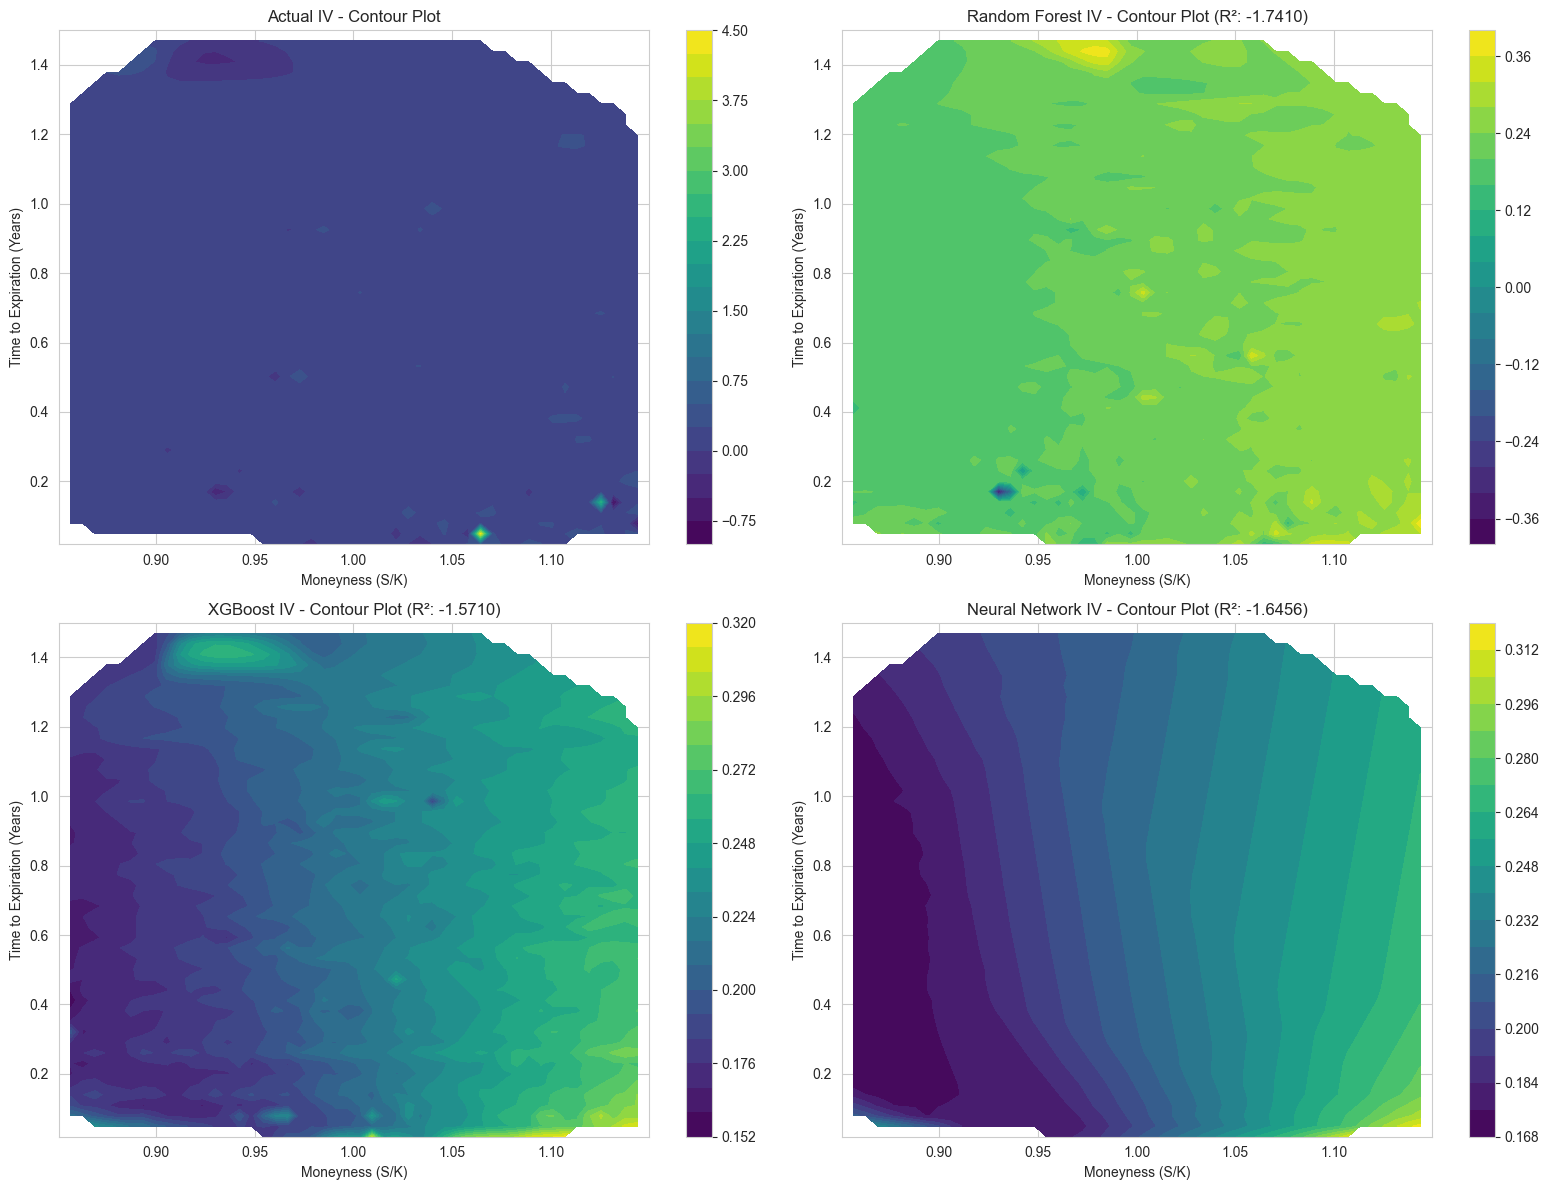


✅ Contour plot visualizations complete!

🎉 ALL REQUIREMENTS COMPLETE!


In [12]:
print("\n" + "="*60)
print("IMPLIED VOLATILITY SURFACE VISUALIZATION")
print("="*60)

from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# We need the original features to create the surface
# Assuming X_test has 'moneyness' and 'T_years' columns
# If column names are different, adjust accordingly

print("\n📊 Creating IV surface visualizations...")

# Check what features are available
print(f"Available features: {list(X_test.columns)}")

# Prepare data for surface plot
# You'll need moneyness (or STRIKE/UNDERLYING_LAST) and time to expiration
surface_data = X_test.copy()
surface_data['actual_iv'] = y_test.values
surface_data['rf_predicted_iv'] = rf_test_pred
surface_data['xgb_predicted_iv'] = xgb_test_pred
surface_data['mlp_predicted_iv'] = mlp_test_pred

# Sample data for cleaner visualization (full dataset might be too dense)
sample_size = min(10000, len(surface_data))
surface_sample = surface_data.sample(n=sample_size, random_state=42)

# Create figure with 4 subplots (actual + 3 model predictions)
fig = plt.figure(figsize=(20, 12))

# Determine which columns to use for X and Y axes
# Common options: 'moneyness' and 'T_years', or 'STRIKE' and 'DTE'
if 'moneyness' in surface_sample.columns and 'T_years' in surface_sample.columns:
    x_col, y_col = 'moneyness', 'T_years'
    x_label, y_label = 'Moneyness (S/K)', 'Time to Expiration (Years)'
elif 'STRIKE' in surface_sample.columns and 'DTE' in surface_sample.columns:
    x_col, y_col = 'STRIKE', 'DTE'
    x_label, y_label = 'Strike Price', 'Days to Expiration'
    # Convert DTE to years for better visualization
    surface_sample['T_years'] = surface_sample['DTE'] / 365.0
    y_col = 'T_years'
    y_label = 'Time to Expiration (Years)'
else:
    print("⚠️ Warning: Could not find moneyness/T_years or STRIKE/DTE columns")
    print("Using first two numerical columns as fallback")
    x_col, y_col = surface_sample.select_dtypes(include=[np.number]).columns[:2]
    x_label, y_label = x_col, y_col

# Create grid for interpolation
x_range = surface_sample[x_col]
y_range = surface_sample[y_col]

# Create mesh grid
xi = np.linspace(x_range.min(), x_range.max(), 50)
yi = np.linspace(y_range.min(), y_range.max(), 50)
XI, YI = np.meshgrid(xi, yi)

# 1. Actual IV Surface
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ZI_actual = griddata((x_range, y_range), surface_sample['actual_iv'], (XI, YI), method='cubic')
surf1 = ax1.plot_surface(XI, YI, ZI_actual, cmap='viridis', alpha=0.8, edgecolor='none')
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.set_zlabel('Implied Volatility')
ax1.set_title('Actual Implied Volatility Surface')
fig.colorbar(surf1, ax=ax1, shrink=0.5)

# 2. Random Forest Predicted IV Surface
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ZI_rf = griddata((x_range, y_range), surface_sample['rf_predicted_iv'], (XI, YI), method='cubic')
surf2 = ax2.plot_surface(XI, YI, ZI_rf, cmap='viridis', alpha=0.8, edgecolor='none')
ax2.set_xlabel(x_label)
ax2.set_ylabel(y_label)
ax2.set_zlabel('Implied Volatility')
ax2.set_title(f'Random Forest Predicted IV Surface\n(Test R²: {rf_test_r2:.4f})')
fig.colorbar(surf2, ax=ax2, shrink=0.5)

# 3. XGBoost Predicted IV Surface
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ZI_xgb = griddata((x_range, y_range), surface_sample['xgb_predicted_iv'], (XI, YI), method='cubic')
surf3 = ax3.plot_surface(XI, YI, ZI_xgb, cmap='viridis', alpha=0.8, edgecolor='none')
ax3.set_xlabel(x_label)
ax3.set_ylabel(y_label)
ax3.set_zlabel('Implied Volatility')
ax3.set_title(f'XGBoost Predicted IV Surface\n(Test R²: {xgb_test_r2:.4f})')
fig.colorbar(surf3, ax=ax3, shrink=0.5)

# 4. Neural Network Predicted IV Surface
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ZI_mlp = griddata((x_range, y_range), surface_sample['mlp_predicted_iv'], (XI, YI), method='cubic')
surf4 = ax4.plot_surface(XI, YI, ZI_mlp, cmap='viridis', alpha=0.8, edgecolor='none')
ax4.set_xlabel(x_label)
ax4.set_ylabel(y_label)
ax4.set_zlabel('Implied Volatility')
ax4.set_title(f'Neural Network Predicted IV Surface\n(Test R²: {mlp_test_r2:.4f})')
fig.colorbar(surf4, ax=ax4, shrink=0.5)

plt.tight_layout()
plt.show()

print("\n✅ IV surface visualizations complete!")

# Additional 2D contour plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Actual IV Contour
ax1 = axes[0, 0]
contour1 = ax1.contourf(XI, YI, ZI_actual, levels=20, cmap='viridis')
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.set_title('Actual IV - Contour Plot')
fig.colorbar(contour1, ax=ax1)

# Random Forest IV Contour
ax2 = axes[0, 1]
contour2 = ax2.contourf(XI, YI, ZI_rf, levels=20, cmap='viridis')
ax2.set_xlabel(x_label)
ax2.set_ylabel(y_label)
ax2.set_title(f'Random Forest IV - Contour Plot (R²: {rf_test_r2:.4f})')
fig.colorbar(contour2, ax=ax2)

# XGBoost IV Contour
ax3 = axes[1, 0]
contour3 = ax3.contourf(XI, YI, ZI_xgb, levels=20, cmap='viridis')
ax3.set_xlabel(x_label)
ax3.set_ylabel(y_label)
ax3.set_title(f'XGBoost IV - Contour Plot (R²: {xgb_test_r2:.4f})')
fig.colorbar(contour3, ax=ax3)

# Neural Network IV Contour
ax4 = axes[1, 1]
contour4 = ax4.contourf(XI, YI, ZI_mlp, levels=20, cmap='viridis')
ax4.set_xlabel(x_label)
ax4.set_ylabel(y_label)
ax4.set_title(f'Neural Network IV - Contour Plot (R²: {mlp_test_r2:.4f})')
fig.colorbar(contour4, ax=ax4)

plt.tight_layout()
plt.show()

print("\n✅ Contour plot visualizations complete!")
print("\n" + "="*60)
print("🎉 ALL REQUIREMENTS COMPLETE!")
print("="*60)